## TechMeet - Demo extract

API includes single/multi-function call in the current form, and has been created as a multi-threaded class object for following tasks - 

1. <b>Object detection</b> - Recognizes multiple objects embdeded in an image. Training has been performed using a boosted wrapper around Google Tensorflow using CIFAR-100 and SID entries and also using a SGD based (Keras) approach trained on 30,000 images specificaly around ecommerce data to pick features like 'sleeve', 'pattern', 'texture', 'material' etc
2. <b>Color palette extraction</b> Later
3. <b>Template match</b> - Later
4. <b>Edge detection</b> - Later
5. <b>Image captioning</b> - Later
6. <b>Description generator</b> - Later
7. <b>Image segmentation</b> - GLater

#### Define source file here

In [11]:
object_detect = "https://catalogueau-null12.netdna-ssl.com/wp-content/uploads/catalogue/kmart/kmart-boxing-day-sale-2015/1.jpg"
# object_detect = "http://blog.recognize.im/wp-content/uploads/2012/11/1.jpg"

#### Load libraries

In [12]:
#import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
from sklearn.cluster import KMeans
import os
import sklearn
from PIL import Image
import urllib.request
import io
import time
import os
import tensorflow as tf
import pandas as pd
import helpers
import validators
print("libraries loaded")

libraries loaded


### URL parser for memory loads

In [13]:
    def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
        resp = urllib.request.urlopen(url)
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
        return image

### Main class for wrapping tensorflow model at the last stage of keras model

In [14]:
def object_recog(url_file,model_name,N_THREADS=64,BATCH_SIZE=1,visualize = 'FALSE',JSON_OUTPUT_FILE = 'output.json'):
    import os
    model_file = 'detection_model_zoo/' + model_name + '.tar.gz' # Path to downloaded model file (.tar)
    PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt') # Path of class labels
    path_to_ckpt = model_name + '/frozen_inference_graph.pb' # Path to frozen model file
    url_file = 'Imagenet_sample_images' # Name of the file containing image ids and urls (without extension)
    json_url_file = url_file + '.json' # Name ssd_mobilenet_v1_coco_11_06_2017of the json file containing image ids and urls
    csv_url_file = url_file + '.csv' # Name of the csv file containing image ids and urls
    downloaded = True # Whether you have downloaded the model file or not
    json_output_file = JSON_OUTPUT_FILE
    n_threads = N_THREADS
    visualize = True
    path_to_labels = PATH_TO_LABELS
    # Download .tar model file and extract the frozen model into a separate directory
    helpers.download_extract_model(model_file=model_file, downloaded=downloaded)

    # Convert .json file containing image ids and urls into a csv file
    helpers.json2csv(json_name=json_url_file, csv_name=csv_url_file)

    # Reading csv file
    li = pd.read_csv(csv_url_file)
    url_li = li['img_url'].tolist()
    id_li = li['img_id'].tolist()

    # Creating model graph
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(path_to_ckpt, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    # Model Execution!
    with detection_graph.as_default():
        im = helpers.url_image_reader(url_li)

        queue = tf.PaddingFIFOQueue(capacity=500, dtypes=tf.uint8, shapes=[(None, None, None)])
        enq_op = queue.enqueue(im)
        inputs = queue.dequeue_many(BATCH_SIZE)
        qr = tf.train.QueueRunner(queue, [enq_op] * n_threads)

        with tf.Session(graph=detection_graph) as sess:

            sess.run(tf.global_variables_initializer())
            coord = tf.train.Coordinator()
            enqueue_threads = qr.create_threads(sess=sess, coord=coord, start=True)

            conversion_time = []
            ix = 1
            res = {}

            category_index = helpers.load_category_index(path_to_labels)

            t = time.time()

            try:
                while not coord.should_stop():
                    image = sess.run(inputs)  # Tensor of dimension (1, None, None, 3)

                    print('Converting Image', ix)

                    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
                    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
                    scores = detection_graph.get_tensor_by_name('detection_scores:0')
                    classes = detection_graph.get_tensor_by_name('detection_classes:0')
                    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

                    t2 = time.time()

                    # The results of object detection
                    (boxes, scores, classes, num_detections) = sess.run([boxes, scores, classes, num_detections],
                                                                        feed_dict={image_tensor: image})

                    conversion_time.append(time.time() - t2)

                    print('Image', ix, 'Conversion Time:', conversion_time[ix - 1], 'sec')

                    # Add results to result dictionary
                    res[id_li[ix - 1]] = {'boxes': np.squeeze(boxes),
                                          'scores': np.squeeze(scores),
                                          'classes': np.squeeze(classes).astype(np.int32),
                                          'num_detections': num_detections}

                    ix += 1

            except tf.errors.OutOfRangeError:
                print('Total Image Conversion Time:', sum(conversion_time), 'sec')
                print('Total Time Consumed:', time.time() - t, 'sec')

            finally:
                coord.request_stop()

                # Dump the contents of the result dictionary into a json file
                helpers.dict2json(res, json_output_file)

                if visualize:
                    # If visualize==True, visualize the object recognition results
                    helpers.visualize(csv_url_file, res, category_index, image_size=(15, 10))

            coord.join(enqueue_threads)

### Illustrative output

#### object recog

Extracting Model: detection_model_zoo/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
Extraction Complete
Reading URLs...
Converting Image 1
Image 1 Conversion Time: 2.3959879875183105 sec
Total Image Conversion Time: 2.3959879875183105 sec
Total Time Consumed: 5.1370849609375 sec


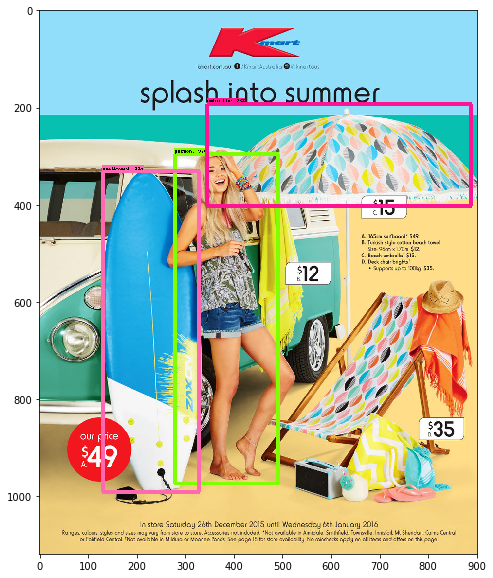

In [15]:
object_recog('Imagenet_sample_images','ssd_mobilenet_v1_coco_11_06_2017',N_THREADS=64,BATCH_SIZE=1,visualize = 'FALSE',JSON_OUTPUT_FILE = 'output.json')

